In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
from sklearn.metrics.pairwise import pairwise_distances

In [46]:
movies_df = pd.read_csv("movies.csv")
rating_df = pd.read_csv("ratings.csv")

In [47]:
movies_df.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [48]:
rating_df.head()

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


Exploratory Data Analysis(EDA)

<BarContainer object of 19 artists>

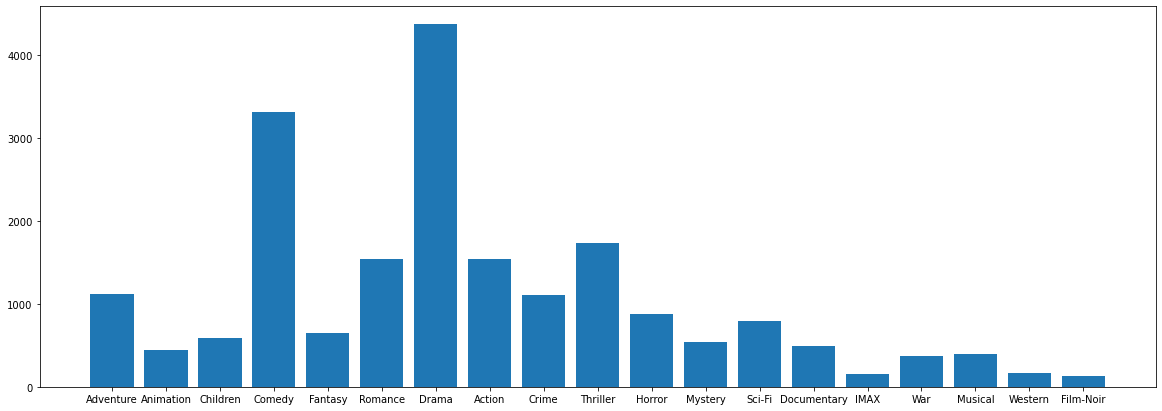

In [49]:
#Most popular genres of movie released
plt.figure(figsize=(20,7))
generlist = movies_df['genres'].apply(lambda generlist_movie : str(generlist_movie).split("|"))
geners_count = {}

for generlist_movie in generlist:
    for gener in generlist_movie:
        if(geners_count.get(gener,False)):
            geners_count[gener]=geners_count[gener]+1
        else:
            geners_count[gener] = 1       
geners_count.pop("(no genres listed)")
plt.bar(geners_count.keys(),geners_count.values())

C:\Users\Arjun V\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='rating', ylabel='Density'>

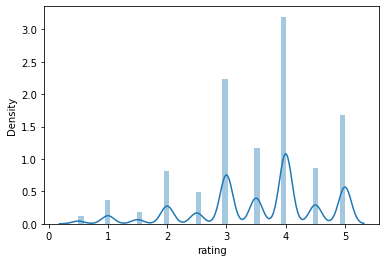

In [50]:
#Distribution of users rating
sns.distplot(rating_df["rating"])

In [51]:
print("Shape of frames: \n"+ " Rating DataFrame"+ str(rating_df.shape)+"\n Movies DataFrame"+ str(movies_df.shape))

Shape of frames: 
 Rating DataFrame(100004, 4)
 Movies DataFrame(9125, 3)


In [52]:
merge_ratings_movies = pd.merge(movies_df, rating_df, on='movieId', how='inner')

In [53]:
merge_ratings_movies.head(2)

,movieId,title,genres,userId,rating,timestamp
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,7,3.0,851866703
1,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,9,4.0,938629179


In [54]:



merge_ratings_movies = merge_ratings_movies.drop('timestamp', axis=1)
merge_ratings_movies.shape

(100004, 5)

In [55]:
#Grouping the rating based on user
ratings_grouped_by_users = merge_ratings_movies.groupby('userId').agg([np.size, np.mean])
ratings_grouped_by_users.head(2)

movieId              rating          
          size         mean   size      mean
userId                                      
1           20  1675.600000     20  2.550000
2           76   354.828947     76  3.486842

In [56]:
ratings_grouped_by_users = ratings_grouped_by_users.drop('movieId', axis = 1)

In [57]:
ratings_grouped_by_movies = merge_ratings_movies.groupby('movieId').agg([np.mean], np.size)
ratings_grouped_by_movies.shape
ratings_grouped_by_movies.head(3)
ratings_grouped_by_movies = ratings_grouped_by_movies.drop('userId', axis=1)

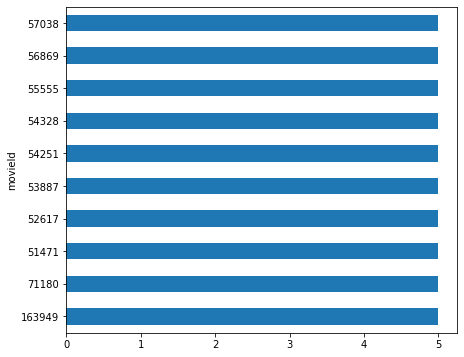

In [58]:
#Movies with high average rating
ratings_grouped_by_movies['rating']['mean'].sort_values(ascending=False).head(10).plot(kind='barh', figsize=(7,6));

,rating
,mean
movieId,
96,1.0
137,1.0
439,1.0
473,1.0
526,1.0


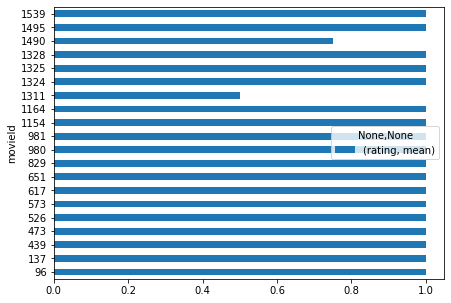

In [59]:
#Movies with low average rating
low_rated_movies_filter = ratings_grouped_by_movies['rating']['mean']< 1.5
low_rated_movies = ratings_grouped_by_movies[low_rated_movies_filter]
low_rated_movies.head(20).plot(kind='barh', figsize=(7,5))
low_rated_movies.head(5)

Content-based filtering

In [60]:
tfidf_movies_genres = TfidfVectorizer(token_pattern = '[a-zA-Z0-9\-]+')

movies_df['genres'] = movies_df['genres'].replace(to_replace="(no genres listed)", value="")

tfidf_movies_genres_matrix = tfidf_movies_genres.fit_transform(movies_df['genres'])

cosine_sim_movies = linear_kernel(tfidf_movies_genres_matrix, tfidf_movies_genres_matrix)

In [61]:
def get_recommendations_based_on_genres(movie_title, cosine_sim_movies=cosine_sim_movies):
    idx_movie = movies_df.loc[movies_df['title'].isin([movie_title])]
    idx_movie = idx_movie.index
    
    sim_scores_movies = list(enumerate(cosine_sim_movies[idx_movie][0]))
    
    sim_scores_movies = sorted(sim_scores_movies, key=lambda x: x[1], reverse=True)

    sim_scores_movies = sim_scores_movies[1:3]

    movie_indices = [i[0] for i in sim_scores_movies]
    
    return movies_df['title'].iloc[movie_indices]

In [62]:
get_recommendations_based_on_genres("Father of the Bride Part II (1995)")

17                        Four Rooms (1995)
18    Ace Ventura: When Nature Calls (1995)
Name: title, dtype: object

In [63]:
def get_recommendation_content_model(userId):
    recommended_movie_list = []
    movie_list = []
    df_rating_filtered = rating_df[rating_df["userId"]== userId]
    for key, row in df_rating_filtered.iterrows():
        movie_list.append((movies_df["title"][row["movieId"]==movies_df["movieId"]]).values) 
    for index, movie in enumerate(movie_list):
        for key, movie_recommended in get_recommendations_based_on_genres(movie[0]).iteritems():
            recommended_movie_list.append(movie_recommended)
            
    for movie_title in recommended_movie_list:
        if movie_title in movie_list:
            recommended_movie_list.remove(movie_title)
    
    return set(recommended_movie_list)
get_recommendation_content_model(1)

{'Adventures in Babysitting (1987)',
 'Around the World in 80 Days (1956)',
 'Assassins (1995)',
 'Before the Rain (Pred dozhdot) (1994)',
 "Bill & Ted's Bogus Journey (1991)",
 'Body Snatchers (1993)',
 'Die Hard: With a Vengeance (1995)',
 'Dragonheart (1996)',
 'Dreamcatcher (2003)',
 'Dune (1984)',
 'Escape from L.A. (1996)',
 'Go West (1925)',
 'Independence Day (a.k.a. ID4) (1996)',
 'King Kong Lives (1986)',
 'Man in the Iron Mask, The (1998)',
 'Misérables, Les (1995)',
 "Mr. Toad's Wild Ride (a.k.a. The Wind in the Willows) (1996)",
 'Navigator: A Mediaeval Odyssey, The (1988)',
 'Othello (1995)',
 'Safe (1995)',
 'Star Wars: Episode IV - A New Hope (1977)',
 'Stargate (1994)',
 'Street Fighter (1994)',
 'Tales from the Darkside: The Movie (1990)',
 'Three Caballeros, The (1945)',
 'Tie That Binds, The (1995)',
 'Toy Story 2 (1999)',
 'Twilight Saga: New Moon, The (2009)',
 'Wallace & Gromit: The Best of Aardman Animation (1996)',
 'Winnie the Pooh and the Blustery Day (1968)'

In [64]:
from sklearn.neighbors import KNeighborsClassifier  
def get_movie_label(movie_id):
    """
    Get the cluster label to which movie belongs by KNN algorithm.  
    :param movie_id: movie id
    :return: genres label to movie belong
    """
    classifier = KNeighborsClassifier(n_neighbors=5)
    x= tfidf_movies_genres_matrix
    y = movies_df.iloc[:,-1]
    classifier.fit(x, y)
    y_pred = classifier.predict(tfidf_movies_genres_matrix[movie_id])
    return y_pred

In [65]:
true_count = 0
false_count = 0
def evaluate_content_based_model():
    for key, colums in movies_df.iterrows():
        movies_recommended_by_model = get_recommendations_based_on_genres(colums["title"])
        predicted_genres  = get_movie_label(movies_recommended_by_model.index)
        for predicted_genre in predicted_genres:
            global true_count, false_count
            if predicted_genre == colums["genres"]:
                true_count = true_count+1
            else:
                false_count = false_count +1
evaluate_content_based_model()
total = true_count + false_count
print("Hit:"+ str(true_count/total))
print("Fault:" + str(false_count/total))

Hit:0.9324383561643835
Fault:0.06756164383561644


# Collaborative Filtering

## Item-Item Filtering

In [66]:
df_movies_ratings=pd.merge(movies_df, rating_df)

In [67]:
df_movies_ratings.head()

,movieId,title,genres,userId,rating,timestamp
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,7,3.0,851866703
1,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,9,4.0,938629179
2,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,13,5.0,1331380058
3,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,15,2.0,997938310
4,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,19,3.0,855190091


In [68]:
ratings_matrix_items = df_movies_ratings.pivot_table(index=['movieId'],columns=['userId'],values='rating').reset_index(drop=True)
ratings_matrix_items.fillna( 0, inplace = True )
ratings_matrix_items.shape

(9066, 671)

In [69]:
ratings_matrix_items.head()

userId,1,2,3,4,5,6,7,8,9,10,...,662,663,664,665,666,667,668,669,670,671
0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,4.0,0.0,...,0.0,4.0,3.5,0.0,0.0,0.0,0.0,0.0,4.0,5.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,5.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0


In [70]:
movie_similarity = 1 - pairwise_distances( ratings_matrix_items.values, metric="cosine" )
np.fill_diagonal( movie_similarity, 0 ) 
ratings_matrix_items = pd.DataFrame( movie_similarity )
ratings_matrix_items.head()

,0,1,2,3,4,5,6,7,8,9,...,9056,9057,9058,9059,9060,9061,9062,9063,9064,9065
0,0.000000,0.394511,0.306516,0.133614,0.245102,0.377086,0.278629,0.063031,0.117499,0.310689,...,0.055829,0.031902,0.079755,0.079755,0.079755,0.079755,0.079755,0.0,0.0,0.055829
1,0.394511,0.000000,0.217492,0.164651,0.278476,0.222003,0.207299,0.223524,0.113669,0.418124,...,0.000000,0.055038,0.068797,0.082557,0.082557,0.137594,0.068797,0.0,0.0,0.000000
2,0.306516,0.217492,0.000000,0.177012,0.370732,0.247499,0.435648,0.127574,0.306717,0.191255,...,0.000000,0.000000,0.000000,0.116226,0.116226,0.000000,0.000000,0.0,0.0,0.000000
3,0.133614,0.164651,0.177012,0.000000,0.179556,0.072518,0.184626,0.501513,0.254630,0.111447,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000
4,0.245102,0.278476,0.370732,0.179556,0.000000,0.272645,0.388476,0.194113,0.367941,0.246846,...,0.000000,0.176845,0.000000,0.117897,0.117897,0.000000,0.000000,0.0,0.0,0.000000


In [71]:
def item_similarity(movieName): 
    try:
        user_inp=movieName
        inp=movies_df[movies_df['title']==user_inp].index.tolist()
        inp=inp[0]

        movies_df['similarity'] = ratings_matrix_items.iloc[inp]
        movies_df.columns = ['movie_id', 'title', 'release_date','similarity']
    except:
        print("Sorry, the movie is not in the database!")

In [72]:
def recommendedMoviesAsperItemSimilarity(user_id):
    user_movie= df_movies_ratings[(df_movies_ratings.userId==user_id) & df_movies_ratings.rating.isin([5,4.5])][['title']]
    user_movie=user_movie.iloc[0,0]
    item_similarity(user_movie)
    sorted_movies_as_per_userChoice=movies_df.sort_values( ["similarity"], ascending = False )
    sorted_movies_as_per_userChoice=sorted_movies_as_per_userChoice[sorted_movies_as_per_userChoice['similarity'] >=0.45]['movie_id']
    recommended_movies=list()
    df_recommended_item=pd.DataFrame()
    user2Movies= rating_df[rating_df['userId']== user_id]['movieId']
    for movieId in sorted_movies_as_per_userChoice:
            if movieId not in user2Movies:
                df_new= rating_df[(rating_df.movieId==movieId)]
                df_recommended_item=pd.concat([df_recommended_item,df_new])
            best10=df_recommended_item.sort_values(["rating"], ascending = False )[1:10] 
    return best10['movieId']

In [73]:
def movieIdToTitle(listMovieIDs):
    movie_titles= list()
    for id in listMovieIDs:
        movie_titles.append(movies_df[movies_df['movie_id']==id]['title'])
    return movie_titles

In [74]:
user_id=50
print("Recommended movies,:\n",movieIdToTitle(recommendedMoviesAsperItemSimilarity(user_id)))

Recommended movies,:
 [262    Outbreak (1995)
Name: title, dtype: object, 266    Pulp Fiction (1994)
Name: title, dtype: object, 266    Pulp Fiction (1994)
Name: title, dtype: object, 262    Outbreak (1995)
Name: title, dtype: object, 266    Pulp Fiction (1994)
Name: title, dtype: object, 266    Pulp Fiction (1994)
Name: title, dtype: object, 266    Pulp Fiction (1994)
Name: title, dtype: object, 266    Pulp Fiction (1994)
Name: title, dtype: object, 266    Pulp Fiction (1994)
Name: title, dtype: object]


# User-Item Filtering

In [75]:
ratings_matrix_users = df_movies_ratings.pivot_table(index=['userId'],columns=['movieId'],values='rating').reset_index(drop=True)
ratings_matrix_users.fillna( 0, inplace = True )
movie_similarity = 1 - pairwise_distances( ratings_matrix_users.values, metric="cosine" )
np.fill_diagonal( movie_similarity, 0 ) 
ratings_matrix_users = pd.DataFrame( movie_similarity )
ratings_matrix_users.head()

,0,1,2,3,4,5,6,7,8,9,...,661,662,663,664,665,666,667,668,669,670
0,0.000000,0.000000,0.000000,0.074482,0.016818,0.000000,0.083884,0.000000,0.012843,0.000000,...,0.000000,0.000000,0.014474,0.043719,0.000000,0.000000,0.000000,0.062917,0.000000,0.017466
1,0.000000,0.000000,0.124295,0.118821,0.103646,0.000000,0.212985,0.113190,0.113333,0.043213,...,0.477306,0.063202,0.077745,0.164162,0.466281,0.425462,0.084646,0.024140,0.170595,0.113175
2,0.000000,0.124295,0.000000,0.081640,0.151531,0.060691,0.154714,0.249781,0.134475,0.114672,...,0.161205,0.064198,0.176134,0.158357,0.177098,0.124562,0.124911,0.080984,0.136606,0.170193
3,0.074482,0.118821,0.081640,0.000000,0.130649,0.079648,0.319745,0.191013,0.030417,0.137186,...,0.114319,0.047228,0.136579,0.254030,0.121905,0.088735,0.068483,0.104309,0.054512,0.211609
4,0.016818,0.103646,0.151531,0.130649,0.000000,0.063796,0.095888,0.165712,0.086616,0.032370,...,0.191029,0.021142,0.146173,0.224245,0.139721,0.058252,0.042926,0.038358,0.062642,0.225086


In [76]:
ratings_matrix_users.idxmax(axis=1)

0      324
1      337
2      378
3      517
4      312
      ... 
666    384
667    453
668    625
669      8
670    597
Length: 671, dtype: int64

In [77]:
ratings_matrix_users.idxmax(axis=1).sample( 10, random_state = 10 )

257    101
601     85
519      7
183    567
271    552
573    561
587    190
43     328
157    514
27     568
dtype: int64

In [78]:
similar_user_series= ratings_matrix_users.idxmax(axis=1)
df_similar_user= similar_user_series.to_frame()

In [79]:
df_similar_user.columns=['similarUser']

In [80]:
df_similar_user.head()

,similarUser
0,324
1,337
2,378
3,517
4,312


In [81]:
movieId_recommended=list()
def getRecommendedMoviesAsperUserSimilarity(userId):
    user2Movies= rating_df[rating_df['userId']== userId]['movieId']
    sim_user=df_similar_user.iloc[0,0]
    df_recommended=pd.DataFrame(columns=['movieId','title','genres','userId','rating','timestamp'])
    for movieId in rating_df[rating_df['userId']== sim_user]['movieId']:
        if movieId not in user2Movies:
            df_new= df_movies_ratings[(df_movies_ratings.userId==sim_user) & (df_movies_ratings.movieId==movieId)]
            df_recommended=pd.concat([df_recommended,df_new])
        best10=df_recommended.sort_values(['rating'], ascending = False )[1:10]  
    return best10['movieId']

In [82]:
user_id=50
recommend_movies= movieIdToTitle(getRecommendedMoviesAsperUserSimilarity(user_id))
print("Movies you should watch are:\n")
print(recommend_movies)

Movies you should watch are:

[6948    Fall, The (2006)
Name: title, dtype: object, 7206    Apollo 13: To the Edge and Back (1994)
Name: title, dtype: object, 6674    How the Grinch Stole Christmas! (1966)
Name: title, dtype: object, 68    Misérables, Les (1995)
Name: title, dtype: object, 3192    How the Grinch Stole Christmas (a.k.a. The Gri...
Name: title, dtype: object, 954    Princess Bride, The (1987)
Name: title, dtype: object, 6959    Indiana Jones and the Kingdom of the Crystal S...
Name: title, dtype: object, 3419    Shrek (2001)
Name: title, dtype: object, 3223    Cast Away (2000)
Name: title, dtype: object]


In [83]:
def get_user_similar_movies( user1, user2 ):
    common_movies = df_movies_ratings[df_movies_ratings.userId == user1].merge(
      df_movies_ratings[df_movies_ratings.userId == user2],
      on = "movieId",
      how = "inner" )
    common_movies.drop(['movieId','genres_x','genres_y', 'timestamp_x','timestamp_y','title_y'],axis=1,inplace=True)
    return common_movies

In [84]:
get_user_similar_movies(587,511)

,title_x,userId_x,rating_x,userId_y,rating_y
0,Leaving Las Vegas (1995),587,4.0,511,4.0
1,"Usual Suspects, The (1995)",587,4.5,511,5.0
2,"Postman, The (Postino, Il) (1994)",587,4.5,511,5.0
3,Taxi Driver (1976),587,4.0,511,5.0
4,Flirting With Disaster (1996),587,4.5,511,3.0
5,Apollo 13 (1995),587,4.5,511,4.0
6,Dumb & Dumber (Dumb and Dumber) (1994),587,0.5,511,3.0
7,Hoop Dreams (1994),587,5.0,511,5.0
8,Pulp Fiction (1994),587,3.5,511,5.0
9,"Shawshank Redemption, The (1994)",587,4.5,511,5.0
